# **Q1.**

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
# manualSeed = 999
# #manualSeed = random.randint(1, 10000) # use if you want new results
# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)

In [2]:
# Root directory for dataset
# dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## **1.**

In [3]:
from torchvision.transforms.transforms import Resize
transform = transforms.Compose(
    [transforms.Resize(image_size),
     transforms.CenterCrop(image_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

train_dataset = torchvision.datasets.FGVCAircraft(root='data',
                                        download=True, transform=transform)
test_dataset = torchvision.datasets.FGVCAircraft(root='data', split = "test",
                                        download=True, transform=transform)
dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')





  0%|          | 0/2753340328 [00:00<?, ?it/s]

Extracting data/fgvc-aircraft-2013b.tar.gz to data


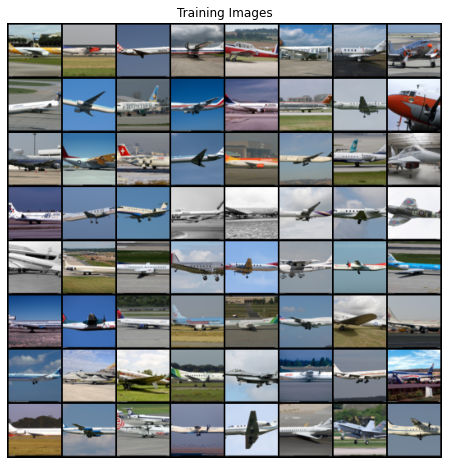

In [ ]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## **2.**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


2. Explanation: It was indicated in the DCGAN study that including a fully connected layer to the discriminator takes a long time to train. Aside from that, each successive layer increases the discriminator's features by a factor of two, whereas the stride reduces the spatial size of the image, requiring four Conv layers to produce a sufficient enough dimension vector for classification.

## **3.**

In [5]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


3. Explanation: The dimension of the latent space is determined by the size of the latent vector. Each point in the latent space should be mapped to a separate output image using an optimal trained generator. If two vectors are close to each other, their output will be close to each other, and if they are far apart, their outputs will be far apart. This indicates that increasing the size of the latent vector provides us more room, and so the generated outputs should be more diverse. Because of vector arithematic, latent spaces can assist in the creation of images with desired consequences. If we have one vector with a zebra with stripes as an output and another vector with a horse as an output, we can combine both vectors to produce a picture with stripes on the horse.

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## **4.**

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/79]	Loss_D: 1.9145	Loss_G: 5.5122	D(x): 0.5781	D(G(z)): 0.6543 / 0.0073
[0/50][50/79]	Loss_D: 0.5134	Loss_G: 31.1606	D(x): 0.8245	D(G(z)): 0.0000 / 0.0000
[1/50][0/79]	Loss_D: 0.8686	Loss_G: 13.3830	D(x): 0.8618	D(G(z)): 0.3571 / 0.0000
[1/50][50/79]	Loss_D: 0.1431	Loss_G: 4.6220	D(x): 0.9539	D(G(z)): 0.0647 / 0.0260
[2/50][0/79]	Loss_D: 0.2357	Loss_G: 5.2446	D(x): 0.8710	D(G(z)): 0.0510 / 0.0088
[2/50][50/79]	Loss_D: 0.9728	Loss_G: 11.0717	D(x): 0.9625	D(G(z)): 0.5230 / 0.0000
[3/50][0/79]	Loss_D: 0.2819	Loss_G: 4.7444	D(x): 0.9175	D(G(z)): 0.1375 / 0.0131
[3/50][50/79]	Loss_D: 0.2453	Loss_G: 5.1075	D(x): 0.8522	D(G(z)): 0.0404 / 0.0141
[4/50][0/79]	Loss_D: 0.6924	Loss_G: 7.4685	D(x): 0.8320	D(G(z)): 0.3314 / 0.0010
[4/50][50/79]	Loss_D: 0.4255	Loss_G: 2.9583	D(x): 0.7374	D(G(z)): 0.0498 / 0.0718
[5/50][0/79]	Loss_D: 0.2906	Loss_G: 3.9269	D(x): 0.8612	D(G(z)): 0.0926 / 0.0407
[5/50][50/79]	Loss_D: 0.8805	Loss_G: 2.9898	D(x): 0.5182	D(G(z)): 0.0121 / 

## **5.**

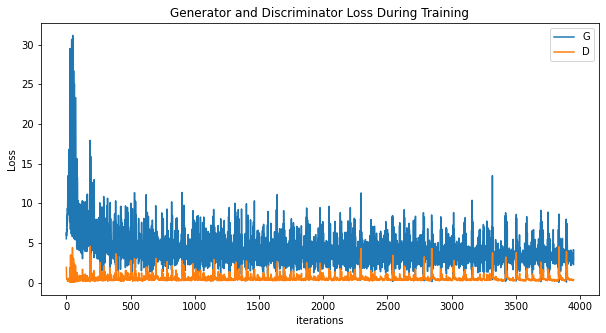

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## **6.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

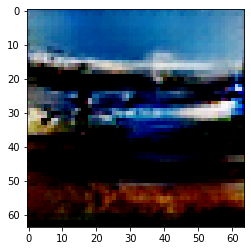

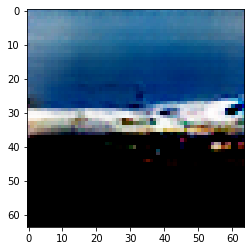

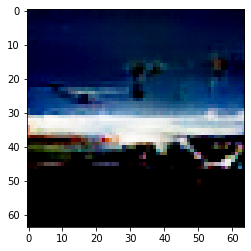

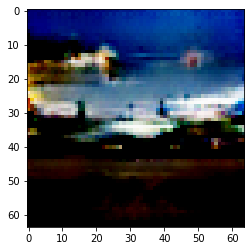

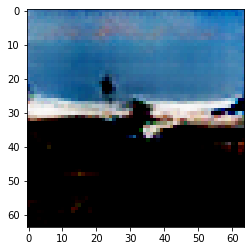

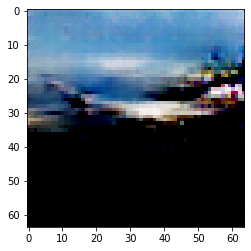

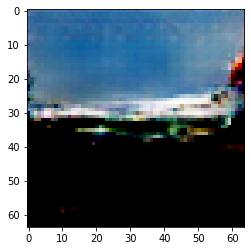

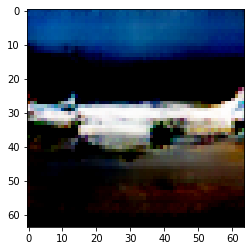

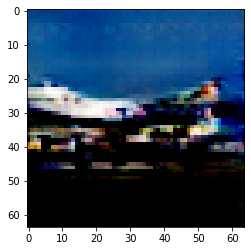

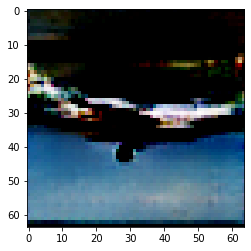

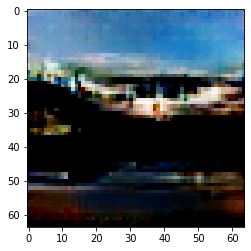

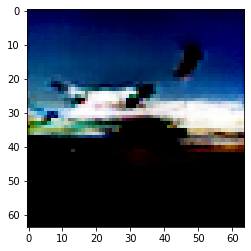

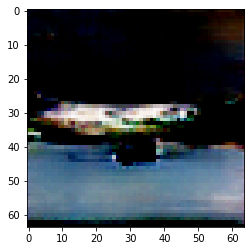

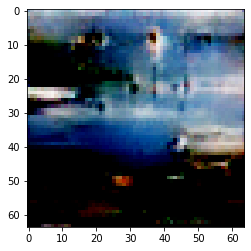

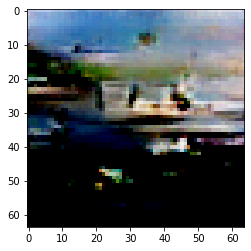

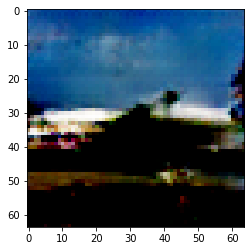

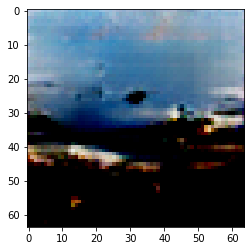

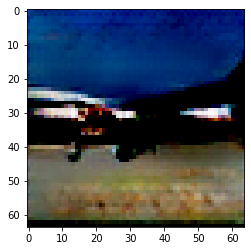

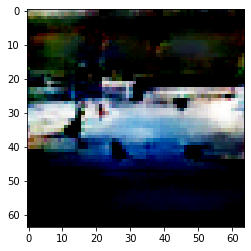

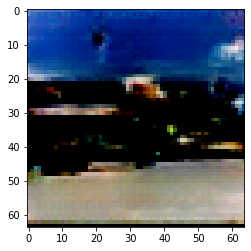

In [ ]:
def generate_samples(n):
    for _ in range(n):
        noise = torch.randn(1, 100, 1, 1, device=device)
        fake = netG(noise)
        fake = torch.reshape(fake, (3,64,64))
        plt.figure()
        plt.imshow(np.transpose(fake.detach().cpu(), (1,2,0)))

generate_samples(20)

## **7a.**

 Yes we can use a pre-trained VGG-16 for this GAN. However, transfer learning will only be used in the discriminator part where we will be using the pre-trained VCG-16 as the top most layer and will be adding more layers which will be trained with the standford dataset. In my opinion, the resulting network would still be a DCGAN because the generator and discriminator are still there and they use the convolution neural network, THe only difference being that the discriminator will be using transfer learning which wil make it more efficient interms of training but no change in terms of the CNN implementation will take place therefore it can be said that the final network would still be a DCGAN. 

### **7b.**

VGG-16 is a deep convolutional neural network which takes images as an input and finds the object name in the image. Thus, VGG-16 can be understood as a classifier. Considering this, VGG-16 is discriminative. As it is clear that VGG-16 acts as a classifier and ouputs the class of the image therefore it cannot be used as a generator because the purpose of the generator is to output an image which cannot be done by the VGG-16 since its architecture is designed to extract features and not to generate images.


## **7c.**

In [7]:
vgg_disc = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [8]:
for param in vgg_disc.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg_disc.classifier[0].in_features
features = list(vgg_disc.classifier.children())[:-7] # Remove classifier
features.extend([nn.Linear(49, 1),
                 nn.Sigmoid()]) # Add our layer with 1 output

num_features_ = vgg_disc.features[-3].in_channels
features_ = list(vgg_disc.features.children())[:-3] # Remove last 3 layer
features_.extend([nn.Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                  nn.ReLU(inplace=True)
                 ]) 

vgg_disc.classifier = nn.Sequential(*features)
vgg_disc.features = nn.Sequential(*features_)

vgg_disc.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(vgg_disc.parameters(), lr=lr*0.01, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        vgg_disc.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = vgg_disc(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = vgg_disc(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = vgg_disc(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/79]	Loss_D: 1.5039	Loss_G: 0.9617	D(x): 0.3724	D(G(z)): 0.3919 / 0.3830
[0/50][50/79]	Loss_D: 1.3929	Loss_G: 0.7068	D(x): 0.4903	D(G(z)): 0.4932 / 0.4932
[1/50][0/79]	Loss_D: 1.3745	Loss_G: 0.7068	D(x): 0.4993	D(G(z)): 0.4932 / 0.4932
[1/50][50/79]	Loss_D: 1.2832	Loss_G: 0.7068	D(x): 0.5474	D(G(z)): 0.4932 / 0.4932
[2/50][0/79]	Loss_D: 1.1504	Loss_G: 0.7069	D(x): 0.6256	D(G(z)): 0.4932 / 0.4932
[2/50][50/79]	Loss_D: 1.7356	Loss_G: 0.3372	D(x): 0.6945	D(G(z)): 0.7454 / 0.7138
[3/50][0/79]	Loss_D: 1.6268	Loss_G: 0.4124	D(x): 0.6346	D(G(z)): 0.6892 / 0.6621
[3/50][50/79]	Loss_D: 1.7154	Loss_G: 0.3760	D(x): 0.6003	D(G(z)): 0.6992 / 0.6866
[4/50][0/79]	Loss_D: 1.5882	Loss_G: 0.4659	D(x): 0.5710	D(G(z)): 0.6405 / 0.6276
[4/50][50/79]	Loss_D: 1.4800	Loss_G: 0.5850	D(x): 0.5267	D(G(z)): 0.5665 / 0.5571
[5/50][0/79]	Loss_D: 1.4838	Loss_G: 0.5950	D(x): 0.5152	D(G(z)): 0.5591 / 0.5516
[5/50][50/79]	Loss_D: 1.5886	Loss_G: 0.5328	D(x): 0.5061	D(G(z)): 0.5961 / 0.5

#Loss Graphs and Generated Images are run in a seperate notebook, CV_Assignment02_part2_sa04324.ipynb.

# **Q2.**

# 1. 
As it is clear from the situation that the original image has been deleted however a large median blurring filter was used on the image which may have affected the fine image details hence we can say that a low resolution image is still present. Thus, the only applicable GAN in this case is the SRGAN. SRGAN are trained in such a way that they can generate a photorealistic high-resolution image when given a low-resolution image (blurred image in our case). The SRGAN architecture consists of three neural networks: a very deep generator network, a discriminator network and a pretrained VGG-16 network. In this situation the low resolution image will be provided to the SRGAN which will then use the perceptual loss function which consists of adversarial and content loss to scale the image to a higher resolution. 


# 2. 
The question clearly mentions that the interns do not have paired images of
pandas and bears and they want to achieve image-to-image translation. Therefore, the best possible solution is to use the CycleGAN which allows image-to-image translation with unpaired data unlike CGAN which requires paired data. The CycleGAN will be provided with two seperate dataset of panda and bear images the network will then be able to map the features of one onto the other. For this the CycleGAN uses two generators G and F and two discriminators Dx and Dy. G would be provided with image X (pandas) and G would map it onto some image of Y (bears). The discriminator Dy would predict if the image already exist in Y or was generated by G. Similar operation would take place for the image Y (bears). 

# 3.
There are two possible GANs that can be used in this case. The two are Style transfer GAN and CycleGAN. However, the provided situation falls under artistic image generation for which style transfer GAN is most suitable. Image style transfer aims to render the content of one
image with the style of another. In our case the van gogh painting style can be transferred to the family photos. The style transfer GAN would allow the user to tune hyperparameters to their liking and have control over the image that’s generated. Moreover, it allows for a factor of variability in generated images due to the addition of “styles” to images at each convolution layer. To be able to train her model she would need the two input images. One being the vangogh painting image(style) and the other being the family photo(content). These both images after going through the generator based on a VGG based CNN encoder-decoder should return a stylized image.